In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from stock import *
from sklearn.metrics import mean_absolute_error, mean_squared_error

import mplfinance as mpf

In [2]:
class StockModel(nn.Module):
    n_features = 5
    n_layers = 1
    
    def __init__(self, n_windows: int = 64, output_size: int = 8):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(self.n_features, n_windows, self.n_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(n_windows, n_windows)
        self.fc2 = nn.Linear(n_windows, n_windows)
        self.fc3 = nn.Linear(n_windows, n_windows)
        self.fc4 = nn.Linear(n_windows, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

model = StockModel()
print(model)

StockModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [3]:
ticker = yf.Ticker("MSFT")
raw_data = ticker.history(interval="1d", period="max")
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(["Date", "Dividends", "Stock Splits"], axis=1)

data = raw_data.pct_change()
data = data.dropna()
data = data.to_numpy()

raw_data = raw_data.to_numpy()
raw_data = raw_data[1:, :]
print(raw_data.shape)
print(data.shape)

(9751, 5)
(9751, 5)


In [4]:
n_windows = 64
n_size = len(data)
n_features = len(data[0])
n_futures = 8

X = np.zeros((n_size - n_windows - n_futures, n_windows, n_features))

for i in range(n_size - n_windows - n_futures):
    X[i] = data[i:i+n_windows]
    # X.append(data[i:i+n_windows])

y = []

for i in range(n_windows, n_size - n_futures):
    t_pct = []
    for j in range(n_futures):
        pct = raw_data[i + j][3] / raw_data[i - 1][3]
        pct = pct - 1
        t_pct.append(pct)  
    y.append(t_pct)

y = np.array(y)

print(X.shape)
print(y.shape)

(9679, 64, 5)
(9679, 8)


In [5]:
dataset = StockDataset(X, y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [7]:
n_epochs = 30

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/30: Loss - 0.0024690320
EPOCH 2/30: Loss - 0.0017497188
EPOCH 3/30: Loss - 0.0017482617
EPOCH 4/30: Loss - 0.0017459352
EPOCH 5/30: Loss - 0.0017469682
EPOCH 6/30: Loss - 0.0017458334
EPOCH 7/30: Loss - 0.0017425478
EPOCH 8/30: Loss - 0.0017436421
EPOCH 9/30: Loss - 0.0017431933
EPOCH 10/30: Loss - 0.0017432192
EPOCH 11/30: Loss - 0.0017478910
EPOCH 12/30: Loss - 0.0017473194
EPOCH 13/30: Loss - 0.0017441855
EPOCH 14/30: Loss - 0.0017417240
EPOCH 15/30: Loss - 0.0017409058
EPOCH 16/30: Loss - 0.0017440595
EPOCH 17/30: Loss - 0.0017393353
EPOCH 18/30: Loss - 0.0017398562
EPOCH 19/30: Loss - 0.0017300266
EPOCH 20/30: Loss - 0.0017319715
EPOCH 21/30: Loss - 0.0017408328
EPOCH 22/30: Loss - 0.0017377429
EPOCH 23/30: Loss - 0.0017308695
EPOCH 24/30: Loss - 0.0017242852
EPOCH 25/30: Loss - 0.0017253096
EPOCH 26/30: Loss - 0.0017206305
EPOCH 27/30: Loss - 0.0017209723
EPOCH 28/30: Loss - 0.0017226113
EPOCH 29/30: Loss - 0.0017294820
EPOCH 30/30: Loss - 0.0017248767


In [8]:
y_pred = model(torch.tensor(X[-1].reshape(1, 64, 5), dtype=torch.float32))
y_pred = y_pred.detach().numpy()
y_pred = y_pred.reshape(8,)
y_pred

array([ 0.00233068, -0.00062411, -0.00218441, -0.0017643 ,  0.00151163,
       -0.00102914,  0.00168047,  0.00301496], dtype=float32)

In [13]:
from datetime import datetime

<Figure size 600x600 with 0 Axes>

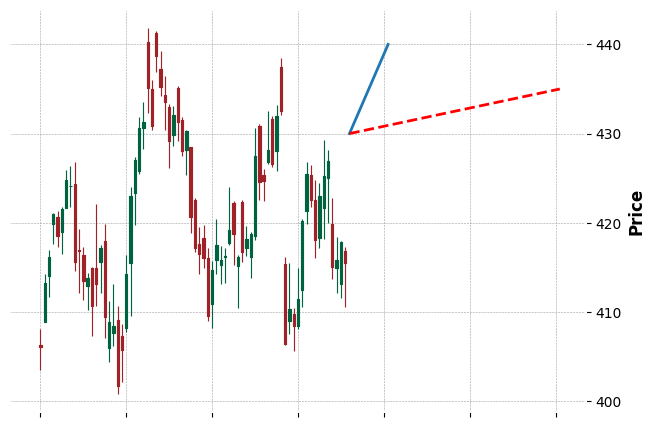

In [41]:
plot_data = raw_data[-64-8:]
df = pd.DataFrame(plot_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

# added = []
# for i in range(len(df)):
#     added.append(np.nan)

# for i in range(8):
#     added[len(df) - 8 + i] = plot_data[len(df) - 9][3] * (1 + y_pred[i])

# apd = mpf.make_addplot(added)

plt.figure(figsize=(6,6))

fig, ax = mpf.plot(
    df,
    type='candle',
    style='charles',
    datetime_format='',
    volume=False,
    returnfig=True,
)

future_x = np.arange(len(df.index), len(df.index) + 10)  # Extend x-axis for predictions
future_y = np.linspace(430, 440, 10)  # Predictive trend prices

ax[0].plot(future_x, future_y)

future_x = np.arange(len(df.index), len(df.index) + 50)  # Extend x-axis for predictions
future_y = np.linspace(430, 435, 50)  # Predictive trend prices

ax[0].plot(future_x, future_y, label='Predictive Trend', linestyle='--', color='red')

plt.show()

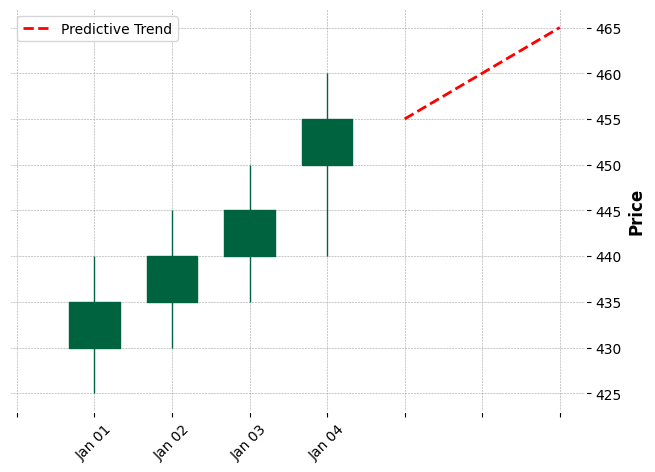

In [33]:
from datetime import datetime, timedelta
import mplfinance as mpf
import pandas as pd
import numpy as np

# Example candlestick data
data = {
    'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04'],
    'Open': [430, 435, 440, 450],
    'High': [440, 445, 450, 460],
    'Low': [425, 430, 435, 440],
    'Close': [435, 440, 445, 455],
    'Volume': [1000, 1200, 1500, 1600]
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create candlestick chart and retrieve Figure and Axes
fig, ax = mpf.plot(
    df,
    type='candle',
    style='charles',
    volume=False,
    returnfig=True
)

# Map internal x-axis positions to actual dates
x_values = np.arange(len(df.index))  # Internal integer x-axis positions
y_values = df['Close'].values

# Add a predictive trend line
future_x = np.arange(len(df.index), len(df.index) + 3)  # Extend x-axis for predictions
future_y = [455, 460, 465]  # Predictive trend prices

# Plot the trend line on the main candlestick axis
ax[0].plot(future_x, future_y, label='Predictive Trend', linestyle='--', color='red')
ax[0].legend()  # Add a legend

# Adjust x-axis ticks to display actual dates, including predictions
# new_dates = list(df.index) + [df.index[-1] + timedelta(days=i) for i in range(1, 4)]
# ax[0].set_xticks(np.arange(len(new_dates)))
# ax[0].set_xticklabels([date.strftime('%Y-%m-%d') for date in new_dates], rotation=45)

# Show the updated figure
plt.show()


In [32]:
future_x

array([4, 5, 6])